# Task-1:- Image Denoising, Extract images from video, Process images of a video 

## Image Denoising

In [1]:
pip install csbdeep

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install n2v


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/24.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.7 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.7 MB 1.7 MB/s eta 0:00:15
   -- ------------------------------------- 1.3/24.7 MB 2.0 MB/s eta 0:00:12
   -- ------------------------------------- 1.8/24.7 MB 2.1 MB/s eta 0:00:11
   --- ------------------------------------ 2.1/24.7 MB 2.3 MB/s eta 0:00:10
   ----- ---------------------------------- 3.1/24.7 MB 2.5 MB/s eta 0:00:09
   ----- ---------------------------------- 3.1/24.7 MB 2.5 MB/s eta 0:00:09
   ----- ---------------------------------- 3.1/24.7 MB 2.5 MB/s eta 0:00:09
   ----- ---------------------------------- 3.1/24.7 MB 2.5 MB/s eta 0:00:09
   ----- ---------------------------------- 3.7/24.7 MB 1.7 MB/s eta 0:00:13
   ------ --------------------------------- 4.2/24.7 MB 1.8 MB/s eta 0:00:12
   -------- -----


Tuning Median Filter...
ksize=3 - PSNR: 26.10, SSIM: 0.6165, MSE: 68.09
ksize=5 - PSNR: 26.52, SSIM: 0.6979, MSE: 56.05
ksize=7 - PSNR: 25.62, SSIM: 0.7011, MSE: 52.94

Tuning Wavelet Denoising...
wavelet=db1, levels=None - PSNR: 26.42, SSIM: 0.7048, MSE: 56.97
wavelet=db1, levels=2 - PSNR: 26.20, SSIM: 0.6774, MSE: 60.87
wavelet=db1, levels=4 - PSNR: 26.42, SSIM: 0.7048, MSE: 56.92
wavelet=sym4, levels=None - PSNR: 26.77, SSIM: 0.7200, MSE: 56.41
wavelet=sym4, levels=2 - PSNR: 26.77, SSIM: 0.7200, MSE: 56.41
wavelet=sym4, levels=4 - PSNR: 27.33, SSIM: 0.7561, MSE: 51.17
wavelet=coif1, levels=None - PSNR: 26.02, SSIM: 0.7036, MSE: 56.13
wavelet=coif1, levels=2 - PSNR: 26.02, SSIM: 0.7036, MSE: 56.13
wavelet=coif1, levels=4 - PSNR: 26.57, SSIM: 0.7382, MSE: 52.49

Tuning Noise2Void...


c:\Users\ayush\anaconda3\envs\tensorflow\lib\site-packages\n2v\models\n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: C:\Users\ayush\Documents\Computer Vision Lab\Lab10\models\n2v_2D_temp
  warnings.warn(


Error in Noise2Void: training images must be evenly divisible by 8 along axes XYZ (axis X has incompatible size 3)
Error in Noise2Void: training images must be evenly divisible by 8 along axes XYZ (axis X has incompatible size 3)
Error in Noise2Void: training images must be evenly divisible by 8 along axes XYZ (axis X has incompatible size 3)
Error in Noise2Void: training images must be evenly divisible by 8 along axes XYZ (axis X has incompatible size 3)

--- Best Results ---
Median (ksize=5) - PSNR: 26.52, SSIM: 0.6979, MSE: 56.05
Wavelet (wavelet=sym4,levels=4) - PSNR: 27.33, SSIM: 0.7561, MSE: 51.17


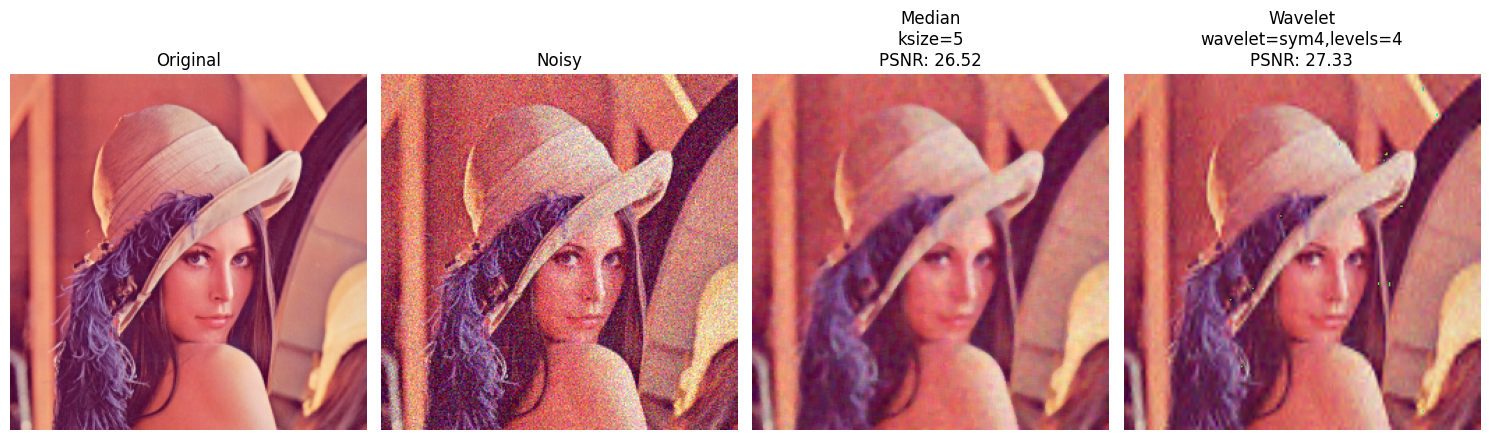

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from n2v.models import N2V
from csbdeep.utils import normalize
from itertools import product

# Load image and add Gaussian noise
def load_noisy_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    noisy = util.random_noise(img, mode='gaussian', var=0.01)
    return img, (noisy * 255).astype(np.uint8)

# Median Filter
def denoise_median(noisy_img, ksize):
    if ksize % 2 == 0:
        ksize += 1  # Ensure odd kernel size
    return cv2.medianBlur(noisy_img, ksize)

# Wavelet Denoising
def denoise_wavelet_skimage(noisy_img, wavelet='db1', levels=None):
    noisy_img = noisy_img / 255.0
    denoised = denoise_wavelet(noisy_img, wavelet=wavelet, mode='soft', wavelet_levels=levels, 
                              channel_axis=-1, rescale_sigma=True)
    return (denoised * 255).astype(np.uint8)

# Noise2Void (using pre-trained model or training)
def denoise_n2v(noisy_img, model_path='models/n2v_2D', train=False, epochs=10, patch_size=64):
    try:
        if train:
            # Train a new model (simplified for demo)
            from n2v.models import N2VConfig
            train_data = noisy_img[np.newaxis, ..., np.newaxis]  # Shape: (1, H, W, C, 1)
            config = N2VConfig(train_data, unet_n_depth=3, train_steps_per_epoch=100, 
                              train_epochs=epochs, patch_size=(patch_size, patch_size))
            model = N2V(config, 'n2v_2D_temp', basedir='models')
            model.train(train_data, train_data)
        else:
            model = N2V(config=None, name='n2v_2D', basedir=model_path)
        noisy_norm = normalize(noisy_img, 1, 99.8, axis=(0,1))
        restored = model.predict(noisy_norm, axes='YXC')
        return (restored * 255).astype(np.uint8)
    except Exception as e:
        print(f"Error in Noise2Void: {e}")
        return None

# Evaluation Metrics
def evaluate(true_img, denoised_img):
    p = psnr(true_img, denoised_img, data_range=255)
    s = ssim(true_img, denoised_img, multichannel=True, data_range=255, channel_axis=-1)
    m = mean_squared_error(true_img.flatten(), denoised_img.flatten())
    return p, s, m

# Parameter Tuning
def tune_parameters(gt, noisy):
    results = []
    
    # Median Filter: Tune kernel size
    median_params = {'ksize': [3, 5, 7]}
    print("\nTuning Median Filter...")
    for ksize in median_params['ksize']:
        denoised = denoise_median(noisy, ksize)
        p, s, m = evaluate(gt, denoised)
        results.append(('Median', f'ksize={ksize}', p, s, m, denoised))
        print(f"ksize={ksize} - PSNR: {p:.2f}, SSIM: {s:.4f}, MSE: {m:.2f}")

    # Wavelet Denoising: Tune wavelet type and levels
    wavelet_params = {'wavelet': ['db1', 'sym4', 'coif1'], 'levels': [None, 2, 4]}
    print("\nTuning Wavelet Denoising...")
    for wavelet, levels in product(wavelet_params['wavelet'], wavelet_params['levels']):
        denoised = denoise_wavelet_skimage(noisy, wavelet, levels)
        p, s, m = evaluate(gt, denoised)
        results.append(('Wavelet', f'wavelet={wavelet},levels={levels}', p, s, m, denoised))
        print(f"wavelet={wavelet}, levels={levels} - PSNR: {p:.2f}, SSIM: {s:.4f}, MSE: {m:.2f}")

    # Noise2Void: Tune epochs and patch size (if training)
    n2v_results = None
    try:
        print("\nTuning Noise2Void...")
        n2v_params = {'epochs': [10, 20], 'patch_size': [64, 128]}
        for epochs, patch_size in product(n2v_params['epochs'], n2v_params['patch_size']):
            denoised = denoise_n2v(noisy, train=True, epochs=epochs, patch_size=patch_size)
            if denoised is not None:
                p, s, m = evaluate(gt, denoised)
                results.append(('Noise2Void', f'epochs={epochs},patch_size={patch_size}', p, s, m, denoised))
                print(f"epochs={epochs}, patch_size={patch_size} - PSNR: {p:.2f}, SSIM: {s:.4f}, MSE: {m:.2f}")
    except Exception as e:
        print(f"Skipping Noise2Void tuning due to error: {e}")

    return results

# Main Flow
if __name__ == "__main__":
    img_path = 'girl.jpeg'  # Replace with your image path
    try:
        gt, noisy = load_noisy_image(img_path)
    except FileNotFoundError as e:
        print(e)
        exit()

    # Run parameter tuning
    results = tune_parameters(gt, noisy)

    # Find best results for each method
    best_results = {}
    for method in ['Median', 'Wavelet', 'Noise2Void']:
        method_results = [r for r in results if r[0] == method]
        if method_results:
            best_result = max(method_results, key=lambda x: x[2])  # Maximize PSNR
            best_results[method] = best_result

    # Print best results
    print("\n--- Best Results ---")
    for method, (name, params, p, s, m, img) in best_results.items():
        print(f"{name} ({params}) - PSNR: {p:.2f}, SSIM: {s:.4f}, MSE: {m:.2f}")

    # Plotting best results
    plt.figure(figsize=(15, 6))
    plt.subplot(1, len(best_results) + 2, 1)
    plt.imshow(gt)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, len(best_results) + 2, 2)
    plt.imshow(noisy)
    plt.title('Noisy')
    plt.axis('off')

    for i, (method, (name, params, p, s, m, img)) in enumerate(best_results.items(), 3):
        plt.subplot(1, len(best_results) + 2, i)
        plt.imshow(img)
        plt.title(f"{name}\n{params}\nPSNR: {p:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Extract images from video and Process images of a video 

In [18]:
import cv2
import os
import numpy as np

# Part 1: Extract Frames from Video
def extract_frames(video_path, output_folder="frames"):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_folder, f"frame_{frame_id:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_id += 1
    cap.release()
    print(f"Extracted {frame_id} frames to '{output_folder}'")
    return frame_id

# Part 2: Process Frames with Different Techniques
def process_frames(input_folder="frames", output_base_folder="processed_frames"):
    techniques = ["adaptive", "gaussian", "canny", "bitwise"]
    for technique in techniques:
        os.makedirs(os.path.join(output_base_folder, technique), exist_ok=True)
    
    files = sorted([f for f in os.listdir(input_folder) if f.endswith(".jpg")])
    for file in files:
        img = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: Could not read image {file}")
            continue

        # Apply image processing techniques
        adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)
        gaussian = cv2.GaussianBlur(img, (5, 5), 0)
        canny = cv2.Canny(img, 100, 200)
        bitwise = cv2.bitwise_not(img)

        # Save processed frames (convert grayscale to BGR for video compatibility)
        cv2.imwrite(os.path.join(output_base_folder, "adaptive", f"adaptive_{file}"), 
                   cv2.cvtColor(adaptive, cv2.COLOR_GRAY2BGR))
        cv2.imwrite(os.path.join(output_base_folder, "gaussian", f"gaussian_{file}"), 
                   cv2.cvtColor(gaussian, cv2.COLOR_GRAY2BGR))
        cv2.imwrite(os.path.join(output_base_folder, "canny", f"canny_{file}"), 
                   cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR))
        cv2.imwrite(os.path.join(output_base_folder, "bitwise", f"bitwise_{file}"), 
                   cv2.cvtColor(bitwise, cv2.COLOR_GRAY2BGR))
    
    print(f"Processed {len(files)} frames into '{output_base_folder}'")

# Part 3: Recreate Videos from Processed Frames
def recreate_videos(input_base_folder="processed_frames", fps=25):
    techniques = ["adaptive", "gaussian", "canny", "bitwise"]
    for technique in techniques:
        input_folder = os.path.join(input_base_folder, technique)
        output_path = f"{technique}_video.mp4"
        frame_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".jpg")])
        if not frame_files:
            print(f"No frames found for {technique}")
            continue
        
        first_frame = cv2.imread(os.path.join(input_folder, frame_files[0]))
        height, width = first_frame.shape[:2]
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        
        for file in frame_files:
            frame = cv2.imread(os.path.join(input_folder, file))
            out.write(frame)
        
        out.release()
        print(f"Video saved as '{output_path}'")

# Part 4: Create Collage from Original Frames
def create_collage(input_folder="frames", output_path="collage.jpg", rows=5, cols=5):
    files = sorted([f for f in os.listdir(input_folder) if f.endswith(".jpg")])[:rows * cols]
    if not files:
        print("No frames available for collage")
        return
    
    images = [cv2.resize(cv2.imread(os.path.join(input_folder, f)), (160, 120)) for f in files]
    collage_rows = []
    for r in range(rows):
        row_imgs = images[r * cols:(r + 1) * cols]
        if row_imgs:
            collage_rows.append(np.hstack(row_imgs))
    
    if collage_rows:
        collage = np.vstack(collage_rows)
        cv2.imwrite(output_path, collage)
        print(f"Collage saved as '{output_path}'")
    else:
        print("Could not create collage due to insufficient images")

# Main Driver Function
def main():
    video_path = "sample.mp4"  # Replace with your video path
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} does not exist")
        return
    
    # Extract frames
    extract_frames(video_path)
    
    # Process frames
    process_frames()
    
    # Recreate videos for each processing technique
    recreate_videos()
    
    # Create collage
    create_collage()

if __name__ == "__main__":
    main()

Extracted 425 frames to 'frames'
Processed 425 frames into 'processed_frames'
Video saved as 'adaptive_video.mp4'
Video saved as 'gaussian_video.mp4'
Video saved as 'canny_video.mp4'
Video saved as 'bitwise_video.mp4'
Collage saved as 'collage.jpg'
